## Chapter 5
# Detection Using Cross Correlation With Whistler Kernel

In [2]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

## **5.2 Kernels**

### **Kernel Extracted From Data**

**Generate Whistler Cuts**

Generate cuts of whistler from the training set, using the AWD output

In [8]:
from database import Database
from sample_detector import SampleDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)
sample = SampleDetector(dataset_loc, site, np.random.choice(database.get_train(),1)[0])
transforms = ['zscore']
transforms_params = [['None']]
cut_params=[2.5,0.3,12,0,0.1]
# database.create_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
#                               cut_params=cut_params, verbose=True, noise=False, train=True, test=False)
X,Y = database.load_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
                              cut_params=cut_params, verbose=True, noise=False, test=False)
X_mean = X.mean(axis=0)#database.whistler_mean(transforms=transforms, transforms_params=transforms_params, cut_params=cut_params)

/home/othniel/wdml/data/databases/awdEvents1/marion/marion_h5/['zscore']_[['None']]_[2.5, 0.3, 12, 0, 0.1]_False/train
samples:  8318


100%|██████████| 8318/8318 [00:38<00:00, 217.77it/s]


**Show examples of whistler cuts**

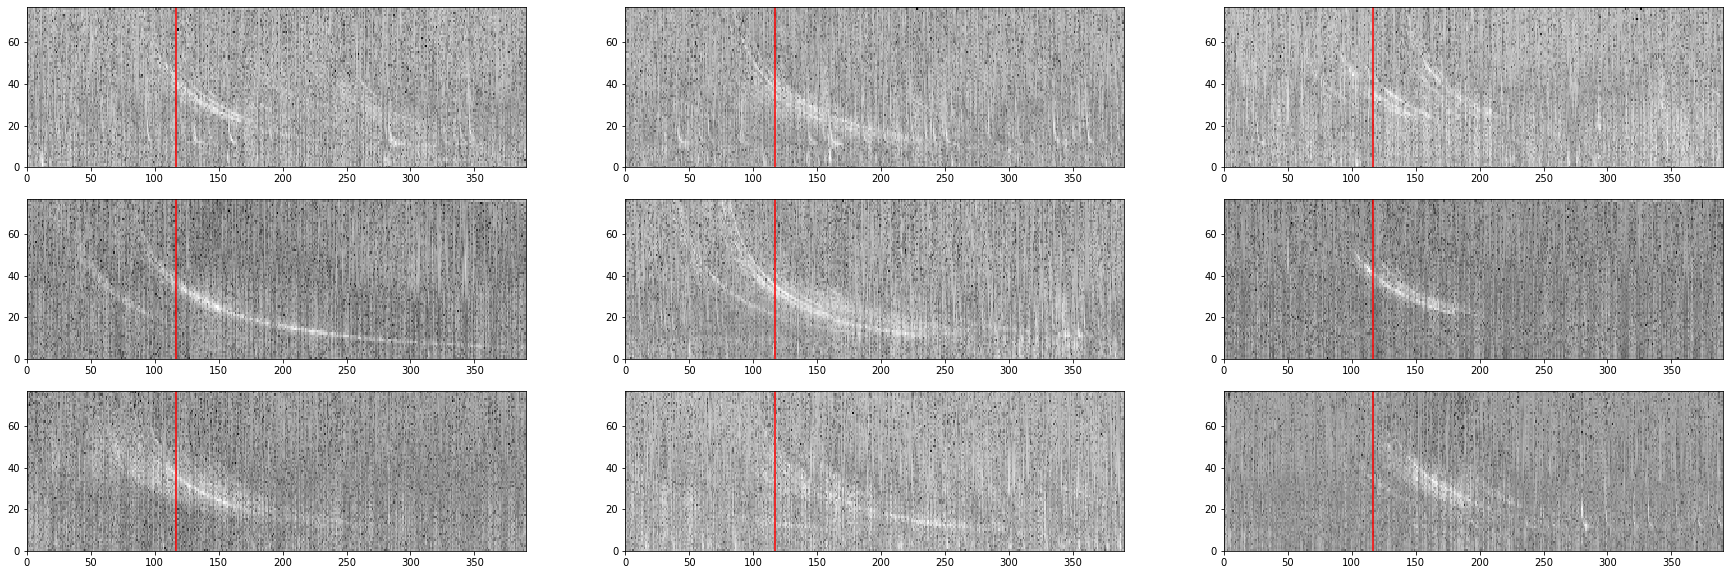

In [9]:
x_size, y_size, ix = 3,3,0
fig, axes = plt.subplots(x_size, y_size, figsize=(x_size*(X_mean.shape[1]/X_mean.shape[0])*2,y_size*2+4))
for x in range(x_size):
    for y in range(y_size):
        axes[x,y].pcolormesh(X[ix], cmap='gray')
        axes[x,y].axvline(int((cut_params[0]*cut_params[1])/sample.get_time_res()), color='r')
        ix += 1
# fig.suptitle('Whislter cuts')
plt.show()

**Mean of the cut as a kernel**

Analyse the mean to define the appropriate cut

(77, 390)


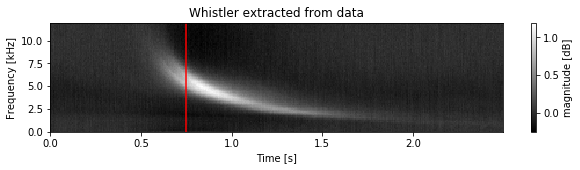

In [10]:
X_mean = X.mean(axis=0)
scale = lambda x: (x-x.min())/(x.max()-x.min())
print(X_mean.shape)
# X_mean = scale(X_mean)
x = np.linspace(0,X_mean.shape[1],X_mean.shape[1]+1)*sample.get_time_res()
y = np.linspace(0,X_mean.shape[0],X_mean.shape[0]+1)*sample.get_freq_res()
fig = plt.figure(figsize=(2*(X_mean.shape[1]/X_mean.shape[0]),2)); 
img = plt.pcolormesh(x,y,X_mean, cmap='gray')
fig.colorbar(mappable=img, label='magnitude [dB]')
plt.axvline((cut_params[0]*cut_params[1]), color='r')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title('Whistler extracted from data')
plt.show()

(x,y) = (0 s,5 kHz)
(x_min,x_max) = (0.550000,1.550000)
(y_min,y_max) = (1.500000,9.500000)


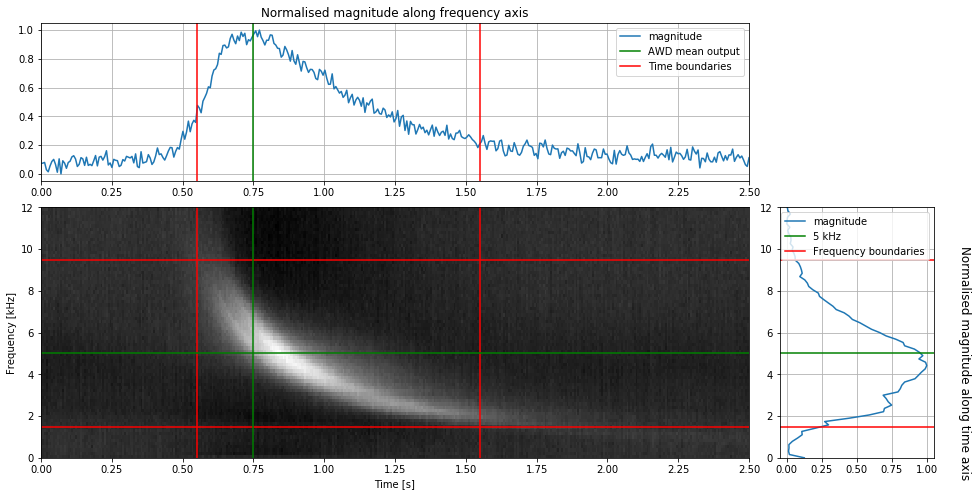

In [11]:
time_max, freq_max = 2.5, 12
# peak coordinate of whistlers
x_c, y_c = time_max*0.3, 5
print("(x,y) = (%d s,%d kHz)" %(x_c, y_c))

x_axis = np.linspace(0,time_max, X_mean.shape[1])
y_axis = np.linspace(0,freq_max, X_mean.shape[0])
X_t, X_f = X_mean.sum(axis=0), X_mean.sum(axis=1)
X_t, X_f = (X_t-X_t.min())/(X_t.max()-X_t.min()), (X_f-X_f.min())/(X_f.max()-X_f.min())

fig = plt.figure(figsize=(16,8))
grid = plt.GridSpec(5, 5, wspace=0.2, hspace=0.4)
spec_ax = fig.add_subplot(grid[2:, 0:-1])
time_ax = fig.add_subplot(grid[:2, 0:-1], sharex=spec_ax)
freq_ax = fig.add_subplot(grid[2:, -1], sharey=spec_ax)

x_min, x_max = x_c-0.2, x_c+0.8
y_min, y_max = 1.5, 9.5
print("(x_min,x_max) = (%f,%f)" %(x_min, x_max))
print("(y_min,y_max) = (%f,%f)" %(y_min, y_max))


spec_ax.autoscale(enable=True, axis='x', tight=True)
spec_ax.autoscale(enable=True, axis='y', tight=True)
time_ax.autoscale(enable=True, axis='x', tight=True)
freq_ax.autoscale(enable=True, axis='y', tight=True)
# spectrogram
spec_ax.pcolormesh(x_axis, y_axis, X_mean, cmap='gray')
spec_ax.axvline(x_min, color='r')
spec_ax.axvline(x_max, color='r')
spec_ax.axhline(y_min, color='r')
spec_ax.axhline(y_max, color='r')
spec_ax.axhline(y_c, color='g')
spec_ax.axvline(x_c, color='g')
spec_ax.set_xticks(np.linspace(0, time_max, 10+1))
spec_ax.set(xlabel='Time [s]', ylabel='Frequency [kHz]')
# time and freq cumulation
# time cum
time_ax.plot(x_axis,X_t)
time_ax.axvline(x_c, color='g')
time_ax.axvline(x_min, color='r')
time_ax.axvline(x_max, color='r')
# time_ax.set(xlabel='Time [s]', ylabel='Normalised cumulation')
time_ax.legend(['magnitude', 'AWD mean output', 'Time boundaries'])
time_ax.set_title('Normalised magnitude along frequency axis')
time_ax.grid()
# freq cum
freq_ax.plot(X_f,y_axis)
freq_ax.axhline(y_c, color='g')
freq_ax.axhline(y_min, color='r')
freq_ax.axhline(y_max, color='r')
freq_ax.set_title('Normalised magnitude along time axis', rotation=270, x=1.2, y=-0.1)
freq_ax.legend(['magnitude', '5 kHz', 'Frequency boundaries'], loc='upper right')
# freq_ax.set_xticks(np.linspace(0, freq_max, freq_max+1))
freq_ax.grid()
plt.show()

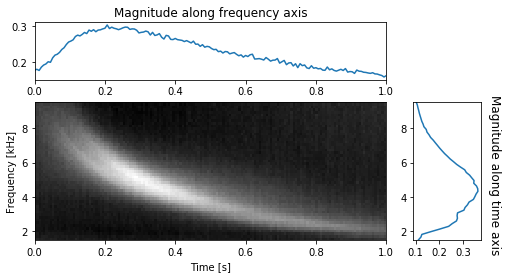

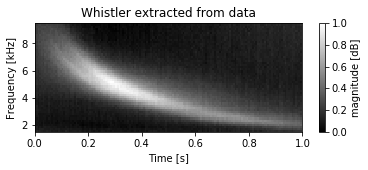

In [12]:
fig = plt.figure(figsize=(8,4))
grid = plt.GridSpec(3, 5, wspace=0.4, hspace=0.4)
spec_ax = fig.add_subplot(grid[1:, 0:-1])
time_ax = fig.add_subplot(grid[:1, 0:-1], sharex=spec_ax)
freq_ax = fig.add_subplot(grid[1:, -1], sharey=spec_ax)
spec_ax.autoscale(enable=True, axis='x', tight=True)
spec_ax.autoscale(enable=True, axis='y', tight=True)
time_ax.autoscale(enable=True, axis='x', tight=True)
freq_ax.autoscale(enable=True, axis='y', tight=True)

kernel = X_mean[int(y_min/sample.get_freq_res()):int(y_max/sample.get_freq_res()),
            int(x_min/sample.get_time_res()):int(x_max/sample.get_time_res())]
kernel = scale(kernel)
x = np.linspace(0, x_max-x_min, kernel.shape[1])
y = np.linspace(y_min, y_max, kernel.shape[0])
# fig = plt.figure(figsize=(2*(_X.shape[1]/_X.shape[0]),2)); 
img = spec_ax.pcolormesh(x,y,kernel, cmap='gray')
spec_ax.set(xlabel='Time [s]', ylabel='Frequency [kHz]')
time_ax.plot(x,kernel.mean(axis=0))
time_ax.set_title('Magnitude along frequency axis')
freq_ax.plot(kernel.mean(axis=1),y)
freq_ax.set_title('Magnitude along time axis', rotation=270, y=-0.13, x=1.2)
plt.show()
fig = plt.figure(figsize=(2*kernel.shape[1]/kernel.shape[0],2))
img = plt.pcolormesh(x,y,kernel, cmap='gray')
fig.colorbar(mappable=img, label='magnitude [dB]')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title('Whistler extracted from data')
plt.show()

**Save the Kernel**

In [86]:
file_name = os.path.join(database_loc, site, 'kernels', 'kernel_data.h5')
file = h5py.File(file_name, 'w')
file_dataset = file.create_dataset(file_name, kernel.shape, np.float32, compression='gzip', data=kernel)
file_dataset.attrs['transforms'] = str(transforms)
file_dataset.attrs['tranforms_params'] = str(transforms_params)
file_dataset.attrs['cut_params'] = str(cut_params)
file_dataset.attrs['final_cut'] = str([1,0.2,8,1.5])
file.close()

### **Bernard Approximation**

**Correlation between Mean and Simulated whistlers**

20.0 0.3 23.27 0.75
35.0 0.52 40.44 0.71
50.0 0.75 71.83 0.67
65.0 0.97 112.55 0.63
80.0 1.2 131.66 0.58


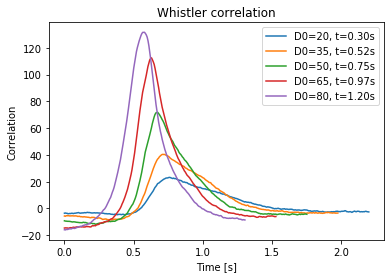

In [16]:
import os, sys
import numpy as np
from scipy import signal
from PIL import Image

sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from database import Database
from sample_detector import SampleDetector
from dataset_simulation import DatasetSimulation

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
site = 'marion'

database = Database(dataset_loc, database_loc, site)
sample = SampleDetector(dataset_loc, site, np.random.choice(database.get_train(),1)[0])
dataset_sim = DatasetSimulation(dataset_sim_loc, sample.get_time_res(), sample.get_freq_res())
An, D0, magnitude = 0.35, 37, 2

# load kernel data
try:
    file_name = os.path.join(database_loc, site, 'kernels', 'kernel_data.h5')
    file = h5py.File(file_name, 'r+')
except Exception as e:
    print('File: %s. Exception: %s'%(file_name,e))
file_data = np.empty(file[file_name].shape,dtype=np.float64)
file[file_name].read_direct(file_data)
kernel_data = np.asarray(file_data)
file.close()

plt.figure()
legend = []
corr = np.flip(signal.correlate(kernel_data, X_mean[int(y_min/sample.get_freq_res()):int(y_max/sample.get_freq_res()),:], mode='valid')[0], axis=0)
x_axis = np.linspace(0,corr.shape[0], corr.shape[0])*sample.get_time_res()
# plt.plot(x_axis, corr)
An, D0, magnitude = 0.45, 20, 1
for D0 in np.linspace(20,80,5):
    data = dataset_sim.whistler_sim(An=An, D0=D0, magnitude=magnitude)
    duration = round(data.shape[1]*sample.get_time_res(),2)
    legend.append('D0=%d, t=%.2fs'%(D0,duration))
    _X_mean = X_mean[int(y_min/sample.get_freq_res()):int(y_max/sample.get_freq_res()),:]
    corr = signal.correlate2d(_X_mean, data, mode='valid')[0]
    x_axis = np.linspace(0,corr.shape[0], corr.shape[0])*sample.get_time_res()
    print(D0, duration, round(corr[corr.argmax()],2), round(corr.argmax()*sample.get_time_res(),2))
    plt.plot(x_axis,corr)
plt.legend(legend)
plt.xlabel('Time [s]')
plt.ylabel('Correlation')
plt.title('Whistler correlation')
plt.show()


**Example of Simulated Kernel to be used**

0.52
0.75
1.05


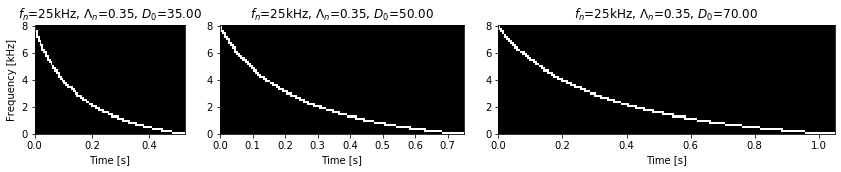

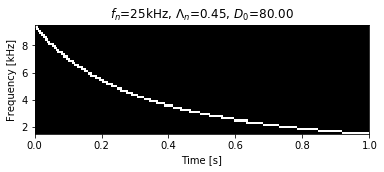

In [19]:
An, D0, magnitude = 0.45, 40, 1
fig = plt.figure(figsize=(2*8,2))
grid = plt.GridSpec(1, 10, wspace=0.6, hspace=0)
axes = [fig.add_subplot(grid[0, 0:2]),fig.add_subplot(grid[0, 2:5]),fig.add_subplot(grid[0,5:-1])]
ix = 0
for D0 in [35,50,70]:
    data = dataset_sim.whistler_sim(An=An, D0=D0, magnitude=magnitude)
    x = np.linspace(0,data.shape[1],data.shape[1]+1)*sample.get_time_res()
    print(round(x[-1],2))
    y = np.linspace(0,data.shape[0],data.shape[0]+1)*sample.get_freq_res()
    img = axes[ix].pcolormesh(x,y,data, cmap='gray')
#     fig.colorbar(mappable=img, label='magnitude [dB]')
    axes[ix].set_xlabel('Time [s]')
    axes[0].set_ylabel('Frequency [kHz]')
    axes[ix].set_title('$f_n$=%dkHz, $\Lambda_n$=%.2f, $D_0$=%.2f'%(25,0.35,D0))
    ix += 1
plt.show()
fig = plt.figure(figsize=(2*3,2))
An, D0, magnitude = 0.45, 80, 3
data = dataset_sim.whistler_sim(An=An, D0=D0, magnitude=magnitude)
x = np.linspace(0, x_max-x_min, data.shape[1])
y = np.linspace(y_min, y_max, data.shape[0])
img = plt.pcolormesh(x,y,data, cmap='gray')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title('$f_n$=%dkHz, $\Lambda_n$=%.2f, $D_0$=%.2f'%(25,An,D0))
plt.show()

**Save the Kernel**

In [7]:
file_name = os.path.join(database_loc, site, 'kernels', 'kernel_bernard.h5')
file = h5py.File(file_name, 'w')
file_dataset = file.create_dataset(file_name, data.shape, np.float32, compression='gzip', data=data)
file_dataset.attrs['An'] = str(An)
file_dataset.attrs['D0'] = str(D0)
file_dataset.attrs['magnitude'] = str(magnitude)
file.close()